# TO DO

Add back in the draws. Reweight the different labels. Figure out how to use non-numerical values classes maybe?

# Import data and access

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from collections import Counter

In [2]:
import kagglehub
from ipynb.fs.full.preprocessing import Preprocessing, CustomDataset
from torch.utils.data import random_split


In [3]:
# Download latest version
path = kagglehub.dataset_download("rajeevw/ufcdata")

print("Path to dataset files:", path)

names = ["\data.csv", "\preprocessed_data.csv", "\\raw_fighter_details.csv", "\\raw_total_fight_data.csv"]

data = pd.read_csv(path + names[0])
'''data.append(pd.read_csv(path + names[0] ))
data.append(pd.read_csv(path + names[1] ))
data.append(pd.read_csv(path + names[2] ))
data.append(pd.read_csv(path + names[3] ))'''


Path to dataset files: C:\Users\joshe\.cache\kagglehub\datasets\rajeevw\ufcdata\versions\2


'data.append(pd.read_csv(path + names[0] ))\ndata.append(pd.read_csv(path + names[1] ))\ndata.append(pd.read_csv(path + names[2] ))\ndata.append(pd.read_csv(path + names[3] ))'

### Create dataset

In [5]:
y, x = Preprocessing(data, 'Winner', ['B_Stance', 'R_Stance', 'weight_class'])
dataset = CustomDataset(x, y)

# Train and test split

In [6]:
training_split = 0.8
length = len(dataset)
train_size  = round(training_split*length)
test_size = length - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Data loaders

In [7]:
from torch.utils.data import DataLoader

# load train and test data samples into dataloader
batach_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batach_size, shuffle=True) 
test_loader = DataLoader(dataset=test_dataset, batch_size=batach_size, shuffle=False)

# Class weighting

In [8]:
from collections import Counter

train_classes = [label.item() for _, label in train_dataset]
Counts = Counter(train_classes)

total = Counts[0] + Counts[1]+ Counts[2]

weight_0 = 100/Counts[0]
weight_1 = 100/Counts[1]
weight_2 = 100/Counts[2]

weightings = torch.Tensor([weight_2, weight_1, weight_0])

# Model (Logistic Regression here)

In [9]:
class LogisticRegression(torch.nn.Module):    
    def __init__(self, n_inputs, n_outputs):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
    
    def forward(self, x):
        # Do not apply sigmoid or softmax here; CrossEntropyLoss will handle it internally.
        y_pred = self.linear(x)
        return y_pred



In [10]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [11]:
# instantiate the model
n_inputs = train_dataset[0][0].size()[0] # makes a 1D vector of 784
n_outputs = 3

# Train model on data

Epoch: 0. Loss: 1.1850874423980713. Accuracy: 47.920133111480865
Epoch: 1. Loss: 0.9305316805839539. Accuracy: 52.99500831946755
Epoch: 2. Loss: 0.9318963885307312. Accuracy: 55.99001663893511
Epoch: 3. Loss: 0.8434725999832153. Accuracy: 58.818635607321134
Epoch: 4. Loss: 0.7230536937713623. Accuracy: 60.48252911813644
Epoch: 5. Loss: 0.9005548357963562. Accuracy: 61.64725457570715
Epoch: 6. Loss: 0.7876855134963989. Accuracy: 62.47920133111481
Epoch: 7. Loss: 0.8454009294509888. Accuracy: 62.81198003327787
Epoch: 8. Loss: 0.7493969202041626. Accuracy: 63.81031613976705
Epoch: 9. Loss: 0.9044480323791504. Accuracy: 64.22628951747089
Epoch: 10. Loss: 0.5792051553726196. Accuracy: 64.30948419301164
Epoch: 11. Loss: 0.6674898266792297. Accuracy: 64.47587354409318
Epoch: 12. Loss: 0.6866279244422913. Accuracy: 64.64226289517471
Epoch: 13. Loss: 0.8696346282958984. Accuracy: 64.89184692179701
Epoch: 14. Loss: 1.0291200876235962. Accuracy: 65.1414309484193
Epoch: 15. Loss: 0.610401749610900

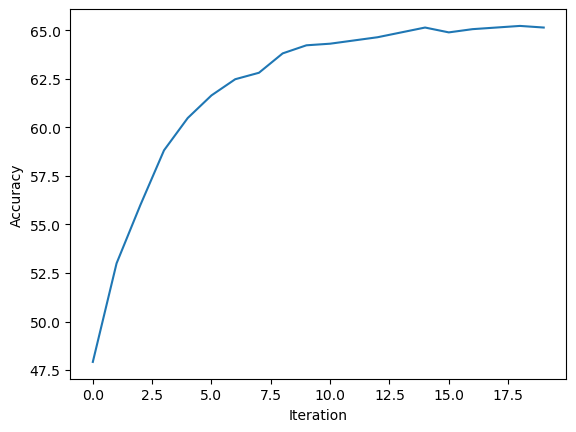

In [14]:
log_regr = LogisticRegression(n_inputs, n_outputs)
# defining the optimizer
#optimizer = torch.optim.Adam(log_regr.parameters(), lr=0.001)
optimizer = torch.optim.SGD(log_regr.parameters(), lr=1e-3)

# defining Cross-Entropy loss
criterion = torch.nn.CrossEntropyLoss()#weight = weightings)
 
epochs = 20
Loss = []
acc = []
for epoch in range(epochs):
    for i, (attribute, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = log_regr(attribute)
        loss = criterion(outputs, labels)
        # Loss.append(loss.item())
        loss.backward()
        optimizer.step()
    Loss.append(loss.item())
    correct = 0
    for attribute, labels in test_loader:
        outputs = log_regr(attribute)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum()
    accuracy = 100 * (correct.item()) / len(test_dataset)
    acc.append(accuracy)
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))

    
import matplotlib.pyplot as plt

plt.plot(acc)
plt.xlabel("Iteration")
plt.ylabel('Accuracy')
plt.show()

Epoch: 0. Loss: 0.8135624527931213. Accuracy: 56.82196339434276
Epoch: 1. Loss: 0.686077356338501. Accuracy: 63.81031613976705
Epoch: 2. Loss: 0.926601231098175. Accuracy: 64.64226289517471
Epoch: 3. Loss: 0.7329722046852112. Accuracy: 62.31281198003328
Epoch: 4. Loss: 0.9787033200263977. Accuracy: 64.64226289517471
Epoch: 5. Loss: 0.6065916419029236. Accuracy: 64.64226289517471
Epoch: 6. Loss: 0.5684369802474976. Accuracy: 62.978369384359404
Epoch: 7. Loss: 0.4641239643096924. Accuracy: 61.480865224625624
Epoch: 8. Loss: 0.8218930959701538. Accuracy: 61.89683860232945
Epoch: 9. Loss: 0.6668896079063416. Accuracy: 63.643926788685526
Epoch: 10. Loss: 0.7934653759002686. Accuracy: 60.89850249584027
Epoch: 11. Loss: 1.1388907432556152. Accuracy: 63.14475873544093
Epoch: 12. Loss: 0.9294894933700562. Accuracy: 62.81198003327787
Epoch: 13. Loss: 0.551028847694397. Accuracy: 62.89517470881864
Epoch: 14. Loss: 1.0033777952194214. Accuracy: 61.56405990016639
Epoch: 15. Loss: 0.4445056617259979

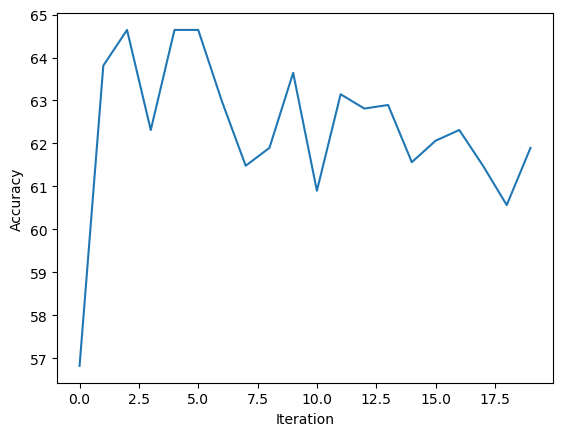

In [13]:
log_regr = LogisticRegression(n_inputs, n_outputs)
# defining the optimizer
optimizer = torch.optim.Adam(log_regr.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(log_regr.parameters(), lr=1e-3)

# defining Cross-Entropy loss
criterion = torch.nn.CrossEntropyLoss(weight = weightings)
 
epochs = 20
Loss = []
acc = []
for epoch in range(epochs):
    for i, (attribute, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = log_regr(attribute)
        loss = criterion(outputs, labels)
        # Loss.append(loss.item())
        loss.backward()
        optimizer.step()
    Loss.append(loss.item())
    correct = 0
    for attribute, labels in test_loader:
        outputs = log_regr(attribute)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum()
    accuracy = 100 * (correct.item()) / len(test_dataset)
    acc.append(accuracy)
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))

    
import matplotlib.pyplot as plt

plt.plot(acc)
plt.xlabel("Iteration")
plt.ylabel('Accuracy')
plt.show()

Epoch: 0. Loss: 1.1772609949111938. Accuracy: 50.0
Epoch: 1. Loss: 0.9547499418258667. Accuracy: 55.24126455906822
Epoch: 2. Loss: 0.8465648889541626. Accuracy: 57.15474209650582
Epoch: 3. Loss: 0.7920070886611938. Accuracy: 60.06655574043261
Epoch: 4. Loss: 0.82429438829422. Accuracy: 61.73044925124792
Epoch: 5. Loss: 0.8967836499214172. Accuracy: 62.562396006655575
Epoch: 6. Loss: 0.6786528825759888. Accuracy: 63.89351081530782
Epoch: 7. Loss: 0.7390357851982117. Accuracy: 64.05990016638935
Epoch: 8. Loss: 0.7484527826309204. Accuracy: 64.55906821963394
Epoch: 9. Loss: 0.588562548160553. Accuracy: 64.72545757071548
Epoch: 10. Loss: 0.9038878679275513. Accuracy: 65.22462562396007
Epoch: 11. Loss: 0.6399363279342651. Accuracy: 65.3910149750416
Epoch: 12. Loss: 0.7480131387710571. Accuracy: 65.55740432612313
Epoch: 13. Loss: 0.8457253575325012. Accuracy: 65.3910149750416
Epoch: 14. Loss: 0.5441948175430298. Accuracy: 65.47420965058237
Epoch: 15. Loss: 0.7318055033683777. Accuracy: 65.55

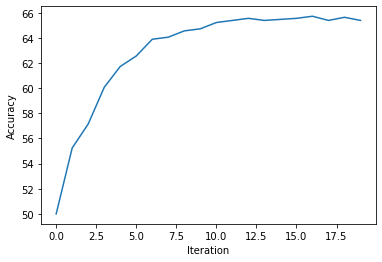

In [13]:
log_regr = LogisticRegression(n_inputs, n_outputs)
# defining the optimizer
#optimizer = torch.optim.Adam(log_regr.parameters(), lr=1e-3)
optimizer = torch.optim.SGD(log_regr.parameters(), lr=1e-3)

# defining Cross-Entropy loss
criterion = torch.nn.CrossEntropyLoss()#weight = weightings)
 
epochs = 20
Loss = []
acc = []
for epoch in range(epochs):
    for i, (attribute, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = log_regr(attribute)
        loss = criterion(outputs, labels)
        # Loss.append(loss.item())
        loss.backward()
        optimizer.step()
    Loss.append(loss.item())
    correct = 0
    for attribute, labels in test_loader:
        outputs = log_regr(attribute)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum()
    accuracy = 100 * (correct.item()) / len(test_dataset)
    acc.append(accuracy)
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))

    
import matplotlib.pyplot as plt

plt.plot(acc)
plt.xlabel("Iteration")
plt.ylabel('Accuracy')
plt.show()